## 单机多卡并行

- 一台机器可以装多卡（1-16）

- 在训练和测试时，将一个小批量计算切分到多个GPU上来达到加速目的

- 常用切分方案

    - 数据并行
    
    - 模型并行
    
    - 通道并行（数据+模型并行）
    

#### 数据并行 vs 模型并行

- 数据并行：将小批量分成n块，每个GPU拿到完整参数计算一块数据的梯度

    - 通常性能好

- 模型并行：将模型分成n块，每个GPU拿到一块模型计算他的前向和方向结果，此时拿到所有数据，别的卡闲置

    - 通常用于模型大到单GPU放不下的情况
    

#### 数据并行

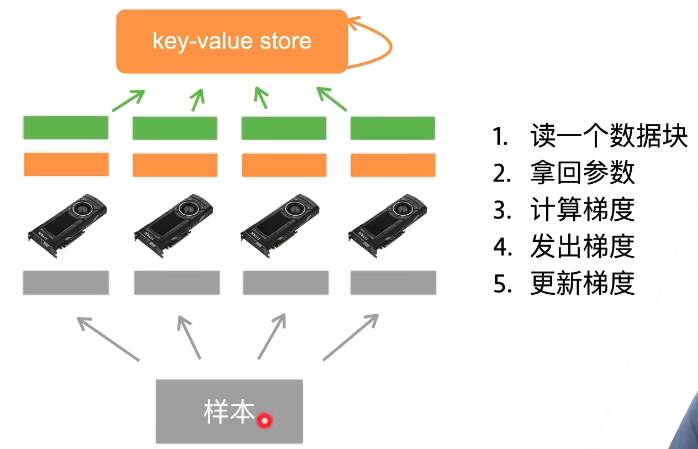
- 多卡训练速度差不多，所以性能好



#### 总结

- 当模型能用单卡计算时，通常使用并行拓展到多卡上

- 模型并行则用在超大模型上（transformer）



## QA

#### 四个GPU，后来2个更大的GPU显存，影响什么？

- 如果性能相同，如都是v100，只是16g 32g的差别，只能训练小显存的GPU的上限的，木桶效应

- 如果性能不同，如double性能的，可以在性能强的上面double 批量，其他的正常批量


#### 数据拆分后，中间需要存储的数据量会增加吗？会降低性能吗？
- 拆分后每个GPU需要保存模型参数和梯度，中间数据量的大小线性于批量大小
- 性能确实会变低，因为批量变小了，整个矩阵运算变小了

#### 数据并行是真的步行？模型并行不是？相当于串行？
- 模型并行能做到一定程度的并行，但是并行程度低

#### 无人车一般用什么硬件芯片呢？
- 一般关心功耗，希望拿到server端性能但是功耗低很多，像手机
    

# 多GPU训练 
## 从0实现代码


In [8]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [9]:
# 简单网络
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10))
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduce='none')

## 向多个设备分发参数
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight: ', new_params[1])
print('b1 grad: ', new_params[1].grad)



b1 weight:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad:  None


In [3]:
# allreduce函数将所有向量相加，并将结果广播给所有GPU
def allreduce(data):
    """ 
        比如把GPU 0外的数据拿到0上面来，做叠加，然后将结果返回给其他的所有GPU
    """
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i][:].device)

data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


In [4]:
# 将一个小批量均匀分布在多个GPU上
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output: ', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output:  (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [5]:
def split_batch(X, y, devices):
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [6]:
# 在小批量上实现多GPU训练
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    ls = [loss(lenet(X_shard, device_W), y_shard).sum() 
        for X_shard, y_shard, device_W in zip(
        X_shards, y_shards, device_params)]

    for l in ls:
        l.backward()
    # 如果框架支持好的话，上面这一段会自动做并行，mxnet和tf应该没问题，pytorch不确定
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad 
                      for c in range(len(devices))])
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])

In [7]:
# 定义训练函数
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    device_params = [get_params(params, d) for d in devices]
    num_eopchs = 10
    animator = d2l.Animator('epoch', 'test aac', xlim=[1, num_eopchs])
    timer = d2l.Timer()
    for epoch in range(num_eopchs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]
        ),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.70，2.0秒/轮，在[device(type='cuda', index=0)]


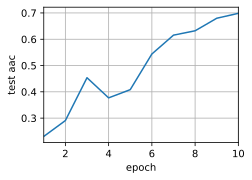

In [10]:
# 在单个GPU上运行
train(num_gpus=1, batch_size=256, lr=0.2)

#### v100性能
- 测试精度：0.67，2.2秒/轮，在[device(type='cuda', index=0)]

#### 3090性能
- 测试精度：0.70，2.0秒/轮，在[device(type='cuda', index=0)]

测试精度：0.50，2.0秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


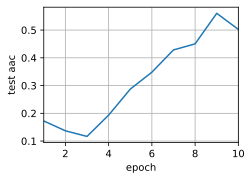

In [13]:
# 增加为2个GPU
# train(num_gpus=2, batch_size=256, lr=0.2)
# train(num_gpus=2, batch_size=256*2, lr=0.2)
train(num_gpus=2, batch_size=256*2, lr=0.2*1.5)

#### 结果分析
- 单卡 测试精度：0.70，2.0秒/轮，在[device(type='cuda', index=0)]
- 双卡 
    - 测试精度：0.65，2.9秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]
- 双卡增大batch size
    - 测试试精度：0.41，1.8秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]
- 双卡增大batch size，增大lr
    - 测试精度：0.50，2.0秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]
- 结果精度没增加，时间也没增加，这个太正常了
- 主要原因： 
    - 数据读取太慢，可以尝试单独数据读取，看看时间；
    - batch_size 不变的话，批量变小的话，性能降低，一般增加GPU还是要保证每个GPU拿到之前的batch size直接加倍，可能精度会降低，性能也没上去，解决测试精度办法之一提高lr,如1.5倍（此时batchsize加倍，但是也不能无限增加，如4卡，4倍size但是4倍lr不一定有效
    - 还可能手写的办法效果不好
    - 还可能是本身lenet模型太小了，还不至于上多卡，无法发挥性能

In [14]:
# 多GPU的简洁实现
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
# 简单网络，考虑之前lenet太简单换成resnet18，相当于原模型50倍计算量的样子
def resnet_18(num_classes, in_channels=1):
    """稍加修改的resnet-18"""
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    d2l.Residual(in_channels, out_channels, use_1x1conv=True,strides=2))
            else:
                blk.append(d2l.Residual(out_channels,  out_channels))
        return nn.Sequential(*blk)
                
    net = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU()) 
    net.add_module('resnet_block1', resnet_block(64, 64, 2, first_block=True))
    net.add_module('resnet_block2', resnet_block(64, 128, 2))
    net.add_module('resnet_block3', resnet_block(128, 256, 2))
    net.add_module('resnet_block4', resnet_block(256, 512, 2))
    net.add_module('global_avg_pool', nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module('fc', nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))

    return net

def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]

    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test accc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            ## 自动拓展到多GPUS
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f}秒/轮')



test acc: 0.92, 11.0秒/轮


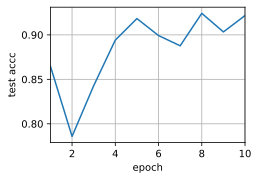

In [16]:
net = resnet_18(10)

# 单卡
train(net, num_gpus=1, batch_size=256, lr=0.1)

#### 结果
- v100 test acc: 0.92, 55.5秒/轮
- 3090 test acc: 0.92, 11.0秒/轮

- 四卡，         test acc: 0.92, 15.4秒/轮
- 四卡调大batch，   test acc: 0.90, 5.2秒/轮
- 四卡调大batch lr， test acc: 0.89, 5.2秒/轮

KeyboardInterrupt: 

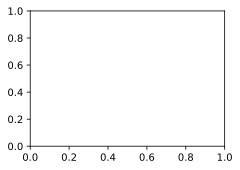

In [21]:
# 四卡
# train(net, num_gpus=4, batch_size=256, lr=0.1)
# 性能不理想，调参
# train(net, num_gpus=4, batch_size=256*4, lr=0.1)
# lr前期较大抖动，还好，只要最后平缓就行
train(net, num_gpus=4, batch_size=256*4, lr=0.1*4)

# batch——size调节性能较好（其实还要调节batch_size，还是小了，带宽性能限制了性能）
# 精度需要调节lr，简单数据集用太大也不行，
# 如fashion-mnist 用512还是大了（此时数据集的多样性不够大，梯度相当于浪费了）

## QA
#### resnet中的卷积层是否全部替换成mlp来实现很深的网络？
- 可以的，1*1可以替换的，有新论文，但是全部替换不建议，基本会overfitting

#### 既然xx norm是一种正则，那么原则上他应该是能像dropout那样加强模型的泛化能力，从而提升网络的泛化能力，那应该能提高模型精度，那为什么说BN只能加快网络训练而对网络精度没影响呢？
- 这个问题很好，不知道，回去查一查   

#### 两个GPU训练时，最后的梯度是两个GPU上的梯度相加么？
- 是的，所谓的mini-batch的梯度就是每个样本的梯度求和，梯度是累加的

#### 为什么参数量大的模型速度不一定慢，或者说flops越多的模型性能越好，又是怎么回事？
- 性能取决于，每算一个东西访问的bit，flops/内存访问，这个比率越高越好，很可能cpu gpu性能瓶颈卡在访问数据上，所以模型数据量小，算力高的操作，比如卷积或者矩阵乘法

#### 为什么多GPU上测试精度和但GPU抖动厉害呢？
- 不是的，抖动是调了lr，这个从2方面考虑，多GPU如果batch size和lr不变的话，那么训练性能和精度都不会变化
- 那么为了增加训练性能，增加了size大小，此时如果不调节lr会使得变小

#### lr太大会导致训练不收敛吗？batch size太大会到时loss nan么？
- 会导致不收敛，size不会nan的（梯度求均值的，所有越大其实越稳定），但是会导致lr不好调

#### 显存如何优化呢？
- 最好直接给框架做了，不行就调小batch size或者网络，除非专家

#### 对于精度来说batch size =1 是最好的吗？
- 是的

#### paramter server可以跟pytroch集合吗？
- 本身pytorch没有的，tf maxnet有，有第三方的（头条byteps）

#### 网络模型使用nn.DataParallel()是不是数据也自动分配到GPUS上
- 是的

#### 为了让网络前几层能训练，我们采用BN，为什么不用多step学习率呢，先大再小？
- 本质可以的，但是不好调，多大？多小？何时？BN方便，简单

#### 在torch的高级并行中，还是将inputs和labels挪到第0块gpu上，会不会导致性能问题呢，因为这些数据最终会被挪一次到其他gpu上
- 通常挪到gpu 0上不是问题，数据相对小（跟收发梯度比不算什么），但是相对额外的操作，但是不挪会出错，